<center>
<h1></h1>
<h1>INF582: INTRODUCTION TO TEXT MINING AND NLP</h1>
<h2>Lab Session 2: Word Embeddings</h2>
<h4>Lecture: Prof. Michalis Vazirgiannis<br>
Lab: Dr. Guokan Shang and Xiao Fei</h4>
<h5>Friday, January 17, 2025</h5>
<h4><b>Student Name: Mindiiarova Renata</b> </h4>
<br>
</center>

<hr style="border:10px solid gray"> </hr>
<p style="text-align: justify;">
This handout includes theoretical introductions, <font color='blue'>coding tasks</font> and <font color='red'>questions</font>. Before the deadline, you should submit to Moodle a <B>.ipynb</B> file named <b>Lastname_Firstname.ipynb</b> containing your notebook (with the gaps filled and your answers to the questions). Your answers should be well constructed and well justified. They should not repeat the question or generalities in the handout. When relevant, you are welcome to include figures, equations and tables derived from your own computations, theoretical proofs or qualitative explanations. One submission is required for each student. The deadline for this lab is <b>January 24
, 2025 08:29 AM</b>. No extension will be granted. Late policy is as follows: ]0, 24] hours late → -5 pts; ]24, 48] hours late → -10 pts; > 48 hours late → not graded (zero).
</p>
<hr style="border:5px solid gray"> </hr>


<h3><b>1. Introduction</b></h2>
<p style="text-align: justify;">
Compared to traditional machine learning approaches (e.g., TF-IDF + SVM) that consider words and combinations of them as unique dimensions of the feature space, deep learning models embed words as vectors in a low-dimensional continuous space where dimensions represent shared latent concepts. The main advantages of this approach are (1) the ability to capture the similarity between words and thus to share predictive power between them; and (2) escaping the curse of dimensionality. Word embeddings can be initialized randomly and learned during training, or be pre-trained. In NLP, pre-trained word vectors obtained with word2vec from very large corpora are often used. The pre-trained word vectors can then be updated during training, or be kept static.
</p>

<h3><b>2. Learning Objective</b></h2>
<p style="text-align: justify;">
In this lab, you will learn about one of the two word2vec variants: skip-gram with negative sampling. We will derive and implement the model by hand using NumPy, and train it on a subset of the Internet Movie Database (IMDB) <a href='http://ai.stanford.edu/ ̃amaas/data/sentiment/'>dataset</a>.
Readings: the original paper introducing skip-gram (along with the other word2vec variant, CBOW) is [<a href='https://arxiv.org/abs/1301.3781'>Mikolov et al., 2013a</a>]. Negative sampling was proposed in a follow-up paper [<a href='https://arxiv.org/abs/1310.4546'>Mikolov et al., 2013b</a>]. Helpful resources to understand how skip-gram works are [<a href='https://arxiv.org/abs/1402.3722'>Goldberg et Levy, 2014</a>] and subsection 3.1 of [<a href='https://arxiv.org/abs/1607.04606'>Bojanowski et al., 2017</a>].
</p>

<h3><b>3. Preprocessing</b></h2>
<p style="text-align: justify;">
Before sampling training examples, the raw data need to be cleaned. Then, each document has to be converted into a list of integers. The integers correspond to indexes in a vocabulary (dictionary) in which the most frequent word has index 1 and only the words that appear a least a certain number of times in the dataset are kept. Index 0 is reserved for out-of-vocabulary words.
</p>

### Importing libraries and downloading the data:

In [1]:
import re
import json
import operator
from bs4 import BeautifulSoup
from collections import Counter
import json
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import islice
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity as cosine
import nltk
nltk.download('stopwords')

import warnings
import urllib
warnings.filterwarnings("ignore")

urllib.request.urlretrieve("https://onedrive.live.com/download?cid=AE69638675180117&resid=AE69638675180117%2151351&authkey=AHMClMM4ep3hNHw", 'imdb_reviews.txt')

path_read = './'
path_write =  './'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 1: </b><br>
Fill the gaps in the next cellto perform the steps described above.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [2]:
min_freq = 5 # retain the words appearing at least this number of times
oov_token = 0 # for out-of-vocabulary words
verbosity = 5

# ========== read and clean reviews ==========

with open(path_read + 'imdb_reviews.txt','r',encoding='utf-8') as file:
    reviews = file.readlines()

tokenizer = TweetTokenizer()

cleaned_reviews = []

for counter,rev in enumerate(reviews):
    rev = rev.lower()
    temp = BeautifulSoup(rev,'lxml')
    text = temp.get_text() # remove HTML formatting
    text = re.sub(' +',' ',text) # strip extra white space
    text = text.strip() # strip leading and trailing white space
    tokens = tokenizer.tokenize(text) # tokenize
    cleaned_reviews.append(tokens)
    if counter % round(len(reviews)/verbosity) == 0:
        print(counter, '/', len(reviews), 'reviews cleaned')

# ========== build vocab ==========
tokens = [token for sublist in cleaned_reviews for token in sublist]
counts = dict(Counter(tokens))

### fill the gap (filter the dictionary 'counts' by retaining only the words that appear at least 'min_freq' times)
counts = {word: count for word, count in counts.items() if count >= min_freq}

with open(path_write + 'counts.json', 'w') as file:
    json.dump(counts, file, sort_keys=True, indent=4)

print('counts saved to disk')

sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)

# assign to each word an index based on its frequency in the corpus
# the most frequent word will get index equal to 1
# 0 is reserved for out-of-vocabulary words
word_to_index = dict([(my_tuple[0],idx) for idx,my_tuple in enumerate(sorted_counts,1)])

# examples
word_to_index['the']
word_to_index["don't"]

with open(path_write + 'vocab.json', 'w') as file:
    json.dump(word_to_index, file, sort_keys=True, indent=4)

print('vocab saved to disk')

# ========== transform each review into a list of word indexes ==========


reviews_ints = []

for i,rev in enumerate(cleaned_reviews):
    sublist = []
    ### fill the gaps (for the tokens that are not in 'word_to_index', use 'oov_token') ###
    for token in rev:
      sublist.append(word_to_index.get(token, oov_token))
    reviews_ints.append(sublist)

with open(path_write + 'doc_ints.txt', 'w') as file:
    for rev in reviews_ints:
        file.write(' '.join([str(elt) for elt in rev]) + '\n')

print('reviews saved to disk')


0 / 25000 reviews cleaned
5000 / 25000 reviews cleaned
10000 / 25000 reviews cleaned
15000 / 25000 reviews cleaned
20000 / 25000 reviews cleaned
counts saved to disk
vocab saved to disk
reviews saved to disk


<h3><b>4. Training example sampling</b></h2>
<p style="text-align: justify;">
Skip-gram is trained on the artificial task of context prediction. The word vectors are learned as a side-effect of training (they are actually the parameters of the model). More precisely, pairs of target and context words (t, Ct ) are sampled by sliding a window over the corpus {0, 1, . . . , T }. For a given instantiation of the window, the word in the middle is the target word t, and the words surrounding it compose the set of positive examples Ct. In practice, the window size is not fixed but uniformly sampled in [1, max window size].

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 2: </b><br>
Fill the first gaps in the sample_examples() function in the next code cell to perform the aforementioned steps.
<hr style="border:10px solid blue"> </hr>
</font></h4>
</p>

In [3]:
def get_windows(seq,n):
    '''
    returns a sliding window (of width n) over data from the iterable
    taken from: https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator/6822773#6822773
    '''
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def sample_examples(docs,max_window_size,n_windows,neg_distr):
    '''generate target,context pairs and negative examples'''
    windows = []
    for i,doc in enumerate(docs):
        ### fill the gaps (get windows of size 'window_size' from the current document. Sample 'window_size' uniformly in {1,...,max_window_size}) ###
        window_size = np.random.randint(1, max_window_size + 1)

        doc_windows = list(get_windows(doc, window_size*2 + 1))
        windows.append(doc_windows)

    windows = [elt for sublist in windows for elt in sublist] # flatten
    print(len(windows))
    random_idxs = np.random.choice(range(len(windows)),size=n_windows,replace=False)
    windows = [windows[idx] for idx in random_idxs]

    all_negs = np.random.choice(len(neg_distr), size=n_negs * len(windows), p=neg_distr) ### fill the gap (sample n_negs*len(windows) negatives according to some probability distribution (negs_distr)###

    return windows,all_negs


<h3><b>5. Objective</b></h2>
<p style="text-align: justify;">
Skip-gram is then trained to assign high probabilities to the words in $C_t$, given t, i.e., to predict well the context of a given target word. This translates into the following log-likelihood:
$$argmax_{θ}\sum^{T}_{t=0}\sum_{c∈C_{t}}logp(c|t;\theta)$$
The set of parameters of the model, θ, contains two matrices of word vectors, say $W_t$ and $W_c$, from which are drawn the vectors of the words when they are used as targets and contexts, respectively. If we denote by V the vocabulary (unique words), and by d the dimensionality of the word embedding space, we can assume that $W_t$ and Wc live respectively in $R^{|V|×d}$ and $R^{d×|V|}$. These two matrices are often referred to as input and output matrices, and it is common practice to use the input matrix, after training, as the final word embeddings.<br>
<b>Softmax vs. negative sampling</b>: The predictions p(c|t; θ) ∀c ∈ $C_t$ are given by looking at the entries of the vector in $R^{1×|V|}$ obtained by passing the vector $w_t$ ∈ $R^d$ of the target word to a simple linear layer parameterized by $W_c$. That is, by multiplying $w_t$ with matrix $W_c$[This operation is fully linear: no nonlinear activation function is applied (there is no hidden layer). Because of this, skip- gram cannot really be considered to be a deep learning model. The term shallow neural network, or log-linear model, is more appropriate. The same holds for CBOW]. Further, to ensure that legitimate probabilities are obtained, we normalize with a softmax:

$$ p(c|t;\theta)=\frac{e^{w_c.w_t}}{\sum_{v∈V}e^{w_v.w_t}}$$
However, this approach is expensive because of the large size of the vocabulary V ($10^5$ or $10^6$).
<b>Negative sampling trick:</b> learning to discriminate. Rather than trying to assign a probability to each single word in the vocabulary, another approach consists in performing independent discrimination tasks. In this scenario, we teach the model to distinguish between words from the true context $C_{t}^{+}$ of a given target word and negative examples $C_{t}^{-}$, i.e., words that are sampled at random from the vocabulary:
$$argmax_{\theta}∑_{t=1}^{T}(∑_{c ∈C_{t}^{+}}logp(c|t;θ)+∑_{c ∈C_{t}^{-}$}log(1-p(c|t;θ)))$$
We now just have independent binary classification tasks to perform. This comes with a major computational advantage: instead of multiplying $w_t$ with the full matrix $W_c$ ∈ $R^{d×|V|}$ (where |V| can get very
large), we now just have to compute a few dot products between $w_t$ and the words in $C_{t}^{+} ∪ C_{t}^{−}$. Assuming that the labels (pos/neg) are indicated by ±1, the individual predictions can be obtained with the sigmoid function σ(x) = $\frac{1}{1-e^{-w_c.w_t}}$ Plugging this in the previous equation, and using the fact that 1 − σ(x) = σ(−x), we obtain the loss:
$$argmin_{\theta}∑_{t=1}^{T}(∑_{c ∈C_{t}^{+}}log(1+e^{-w_c.w_t})+∑_{c ∈C_{t}^{-}$}log(1+e^{w_c.w_t}))$$
Note that in practice, the negative examples are not sampled uniformly but proportionally to their dampened frequency (square root of their frequency, to be exact)[<a href='https://arxiv.org/abs/1607.04606'>Bojanowski et al., 2017</a>]

<b>Note that in our code, both $W_c$ and $W_t$ ∈ $R^{|V|xd}$  so the word embedding of the target and context can be accessed by $W_t[target,]$ and $W_c[context,]$</b>

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 3: </b><br>
Fill the second gap in the sample_examples() function in the previous code cell to implement negative exampkle sampling.
<hr style="border:10px solid blue"> </hr>
</font></h4>

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 4: </b><br>
Fill the gaps in the compute_loss() function of the next cell to compute the loss for one training example.
<hr style="border:10px solid blue"> </hr>
</font></h4>
</p>

In [4]:
def compute_dot_products(pos,negs,target):
  # pos:list contaning the indices of the positive context
  # negs:list contaning the indices of the negative context
  # target: the index of the target word
    pos = np.array(pos)
    negs = np.array(negs)
    combined = np.concatenate([pos, negs])
    prods = Wc[combined,:] @ Wt[target,:] # (n_pos+n_negs,d) X (d,) -> (n_pos+n_negs,)
    return prods

def compute_loss(prodpos,prodnegs):
  # prodpos: wc.wt for positive context
  # prodnegs: wc.wt for negative context
  # wt: word embedding for the target word
  # wc: word embedding for the context
    '''prodpos and prodnegs are numpy vectors containing the dot products of the context word vectors with the target word vector'''
    ### fill the gaps ###
    term_pos, term_negs = np.log(1 + np.exp(-prodpos)), np.log(1 + np.exp(prodnegs))
    return np.sum(term_pos) + np.sum(term_negs)

<h3><b>6. Computing the gradient</b></h2>
<p style="text-align: justify;">
Skip-gram is trained with SGD. We thus need to compute the gradient to perform updates at each training iteration. Let us consider our loss for a given training example (t, $C_{t}^{+} , C_{t}^{−}$ ):
$$L(t, C_{t}^{+} , C_{t}^{−}) = \sum_{c \in \mathcal{C}_t^+ } \log \big(1+e^{-w_c \cdot w_t}\big) + \sum_{c \in \mathcal{C}_t^-} \log \big(1+e^{w_c \cdot w_t}\big)$$
$L$ is a function of the target word $t$ and of all context words, i.e., all words in $\mathcal{C}_t^+ \cup \mathcal{C}_t^-$.
</p>


<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 1 (3 points): </b><br>
Compute the partial derivatives of the loss w.r.t one positive example and one negative example, $\frac{\partial L}{\partial w_{c^+}}$ and $\frac{\partial L}{\partial w_{c^\text{-}}}$.
<hr style="border:10px solid red"> </hr>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 1: </b><br>
Your answer here.


$$
\frac{\partial L}{\partial w_{c^+}} = -\frac{e^{-w_{c^+} \cdot w_t}}{1 + e^{-w_{c^+} \cdot w_t}} \cdot w_t.
$$
$$
\frac{\partial L}{\partial w_{c^-}} = \frac{e^{w_{c^-} \cdot w_t}}{1 + e^{w_{c^-} \cdot w_t}} \cdot w_t.
$$

<hr style="border:10px solid green"> </hr>
</font></h4>

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 2 (3 points): </b><br>
Compute the partial derivative of the loss w.r.t. the target word, $\frac{\partial L}{\partial w_t}$
<hr style="border:10px solid red"> </hr>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 2: </b><br>
Your answer here.

$$
\frac{\partial}{\partial w_t} \log(1 + e^{-w_{c^+} \cdot w_t}) = -\frac{e^{-w_{c^+} \cdot w_t}}{1 + e^{-w_{c^+} \cdot w_t}} \cdot w_{c^+}.
$$

$$
\frac{\partial}{\partial w_t} \log(1 + e^{w_{c^-} \cdot w_t}) = \frac{e^{w_{c^-} \cdot w_t}}{1 + e^{w_{c^-} \cdot w_t}} \cdot w_{c^-}.
$$
$$
\frac{\partial L}{\partial w_t} = \sum_{c \in C_t^+} -\frac{e^{-w_c \cdot w_t}}{1 + e^{-w_c \cdot w_t}} \cdot w_c
+ \sum_{c \in C_t^-} \frac{e^{w_c \cdot w_t}}{1 + e^{w_c \cdot w_t}} \cdot w_c.
$$

<hr style="border:10px solid green"> </hr>
</font></h4>

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 5: </b><br>
Fill the gaps in the compute_gradients() function in the next cell to compute the partial derivatives for one training example.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [10]:
def compute_gradients(pos,negs,target,prodpos,prodnegs, Wt, Wc):
    # Wt is the targe embedding matrix of dimension (#vocab, d) where d is the embedding dimension
    # Wc is the context embedding matrix of dimension (#vocab, d) where d is the embedding dimension
    factors_pos = 1/(np.exp(prodpos)+1) # vector of shape (n_pos,1)
    factors_negs = 1/(np.exp(-prodnegs)+1) # vector of shape (n_negs,1)


    ### fill the gaps using factors_pos, factors_negs, Wt and Wc###
    partial_pos = np.array([factors_pos[k,] * -Wt[target,] for k in range(len(factors_pos))]) # (n_pos,1) X (1,d) -> (n_pos,d), question 1 results
    partial_negs = np.array([factors_negs[k,] * Wt[target,] for k in range(len(factors_negs))]) #question 1 results

    # target word
    term_pos = -factors_pos * Wc[pos, :]
    term_negs = factors_negs * Wc[negs, :]
    partial_target = np.sum(term_pos,axis=0) + np.sum(term_negs,axis=0)

    '''
    # hint: NumPy broadcasting example
    import numpy as np
    A = np.array([[1,2,3],[1,2,3],[1,2,3]])
    a = np.array([1,10,100]).reshape(-1,1)
    A * a
    '''

    return partial_pos, partial_negs,partial_target


def my_cos_similarity(word1,word2):
    sim = cosine(Wt[vocab[word1],].reshape(1,-1),Wt[vocab[word2],].reshape(1,-1))
    return round(float(sim),4)

<h3><b>7. Performing updates</b></h2>
<p style="text-align: justify;">
The model is trained via stochastic gradient descent.
The representation of each word is updated based on its corresponding partial derivative.
For instance, for a positive word at iteration $n$, we perform the following update:

\begin{equation}
w_{c^+_{~n+1}} = w_{c^+_{~n}} - \gamma_n \frac{\partial L}{\partial w_{c^+_{~n}}}
\end{equation}

\noindent where $\gamma_n$ is the learning rate at iteration $n$.
Note that we use $\gamma_n$ and not $\gamma$ because the learning rate is not fixed, but annealed during training.
The schedule we use is $\gamma_n =  \frac{\gamma_0}{1+\text{decay}\times n}$, where decay $=10^{-6}$.
</p>

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 6: </b><br>
Fill the gaps in the nested for loop of the next cell to perform the updates.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [8]:
# = = = = = = = = = = = = = = = = = = = = =
stpwds = set(stopwords.words('english'))

max_window_size = 5 # extends on both sides of the target word
n_windows = int(1e6) # number of windows to sample at each epoch
n_negs = 5 # number of negative examples to sample for each positive
d = 30 # dimension of the embedding space
n_epochs = 15
lr_0 = 0.025
decay = 1e-6

with open(path_read + 'doc_ints.txt', 'r') as file:
    docs = file.read().splitlines()

docs = [[int(eltt) for eltt in elt.split()] for elt in docs]

with open(path_read + 'vocab.json', 'r') as file:
    vocab = json.load(file)

vocab_inv = {v:k for k,v in vocab.items()}

with open(path_read + 'counts.json', 'r') as file:
    counts = json.load(file)

token_ints = range(1,len(vocab)+1) # list of tokens from which we sample all_negs
neg_distr = [counts[vocab_inv[elt]] for elt in token_ints]
neg_distr = np.sqrt(neg_distr)
neg_distr = neg_distr/sum(neg_distr) # normalize

# ========== train model ==========

total_its = 0

Wt = np.random.normal(size=(len(vocab)+1,d)) # + 1 is for the OOV token
Wc = np.random.normal(size=(len(vocab)+1,d))

for epoch in range(n_epochs):

    windows,all_negs = sample_examples(docs,max_window_size,n_windows,neg_distr)
    print('training examples sampled')

    np.random.shuffle(windows)

    total_loss = 0


    for i,w in enumerate(windows):

        target = w[int(len(w)/2)] # elt at the center
        pos = list(w)
        del pos[int(len(w)/2)] # all elts but the center one

        negs = all_negs[n_negs*i:n_negs*i+n_negs]

        prods = compute_dot_products(pos,negs,target)
        prodpos = prods[0:len(pos),]
        prodnegs = prods[len(pos):(len(pos)+len(negs)),]

        partials_pos,partials_negs,partial_target = compute_gradients(pos,negs,target,prodpos,prodnegs, Wt, Wc)

        lr = lr_0 * 1/(1+decay*total_its)
        total_its += 1

        ### fill the gaps (perform the updates) ###
        Wt[target, ] -= lr * partial_target
        Wc[pos, ] -= lr * partials_pos
        Wc[negs, ] -= lr * partials_negs

        total_loss += compute_loss(prodpos,prodnegs)
    print('epoch', epoch+1 , '/', n_epochs ,' finished, loss: ', total_loss/(i+1), 'lr:', lr)


np.save(path_write + 'input_vecs',Wt,allow_pickle=False) # pickle disabled for portability reasons
np.save(path_write + 'output_vecs',Wc,allow_pickle=False)

print('word vectors saved to disk')

6399234
training examples sampled
epoch 1 / 15  finished, loss:  11.33082031135685 lr: 0.012500006250003127
6399056
training examples sampled
epoch 2 / 15  finished, loss:  7.949087827393096 lr: 0.008333336111112038
6399156
training examples sampled
epoch 3 / 15  finished, loss:  7.278011556199585 lr: 0.006250001562500392
6399980
training examples sampled
epoch 4 / 15  finished, loss:  6.950276219027354 lr: 0.005000001000000201
6399290
training examples sampled
epoch 5 / 15  finished, loss:  6.74168566887392 lr: 0.0041666673611112275
6399082
training examples sampled
epoch 6 / 15  finished, loss:  6.6203341080551485 lr: 0.0035714290816327263
6399830
training examples sampled
epoch 7 / 15  finished, loss:  6.496631415419668 lr: 0.003125000390625049
6399204
training examples sampled
epoch 8 / 15  finished, loss:  6.442009154920877 lr: 0.002777778086419788
6399496
training examples sampled
epoch 9 / 15  finished, loss:  6.354632954711258 lr: 0.0025000002500000255
6398618
training examples

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 7: </b><br>
Train the model for several epochs. Monitor your loss to verify that the model learns. Then, fill the gaps at the last code cell to compute some similarities and visualize the learned embeddings.
<hr style="border:10px solid blue"> </hr>
</font></h4>

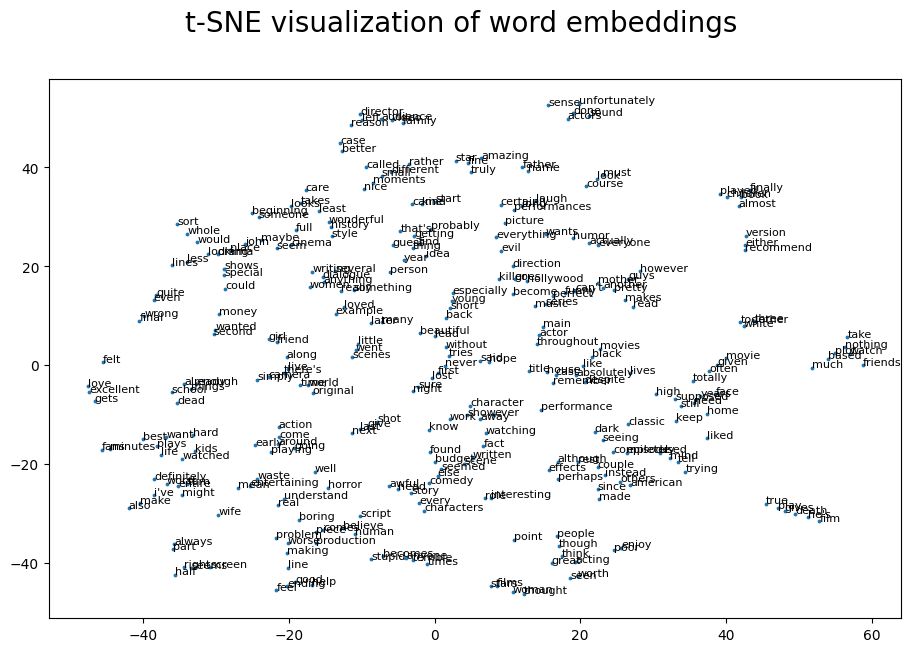

In [9]:
Wt = np.load(path_write + 'input_vecs.npy')
Wc = np.load(path_write + 'output_vecs.npy')
# ========== sanity checks ==========
# = = some similarities = =
### fill the gaps (compute the cosine similarity between some (un)related words, like movie/film/banana ###

word1 = "movie"
word2 = "film"

embed_1 = Wt[vocab[word1],].reshape(1,-1)
embed_2 = Wt[vocab[word2],].reshape(1,-1)
sim = cosine(embed_1, embed_2)
# = = visualization of most frequent tokens = =

n_plot = 500
mft = [vocab_inv[elt] for elt in range(1,n_plot+1)]

# exclude stopwords and punctuation
keep_idxs = [idx for idx,elt in enumerate(mft) if len(elt)>3 and elt not in stpwds]
mft = [mft[idx] for idx in keep_idxs]
keep_ints = [list(range(1,n_plot+1))[idx] for idx in keep_idxs]
Wt_freq = Wt[keep_ints,]

### fill the gaps (perfom PCA (10D) followed by t-SNE (2D). For t-SNE, you can use a perplexity of 5.) ###
### for t-SNE, see https://lvdmaaten.github.io/tsne/#faq ###
my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2, perplexity=5, random_state=42)

my_pca_fit = my_pca.fit_transform(Wt_freq)
my_tsne_fit = my_tsne.fit_transform(my_pca_fit)

fig, ax = plt.subplots()
ax.scatter(my_tsne_fit[:, 0], my_tsne_fit[:, 1], s=3) ### fill the gap ###
for x, y, token in zip(my_tsne_fit[:, 0], my_tsne_fit[:, 1], mft): ### fill the gap ###
    ax.annotate(token, xy=(x,y), size=8)

fig.suptitle('t-SNE visualization of word embeddings',fontsize=20)
fig.set_size_inches(11,7)
fig.savefig(path_write + 'word_embeddings.pdf',dpi=300)
fig.show()


<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 3 (4 points): </b><br>
Observe and interpret your similarity values and your plot. What can you say about the embedding space?
<hr style="border:10px solid red"> </hr>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 3: </b><br>
Your answer here.
In the graph, it can be seen that similar words such as "movie","film","actor","title" have close embeddings and are located close to each other, which confirms their semantic proximity. In addition, genre-related words such as "comedy" and "drama" also form local clusters, and evaluative terms such as "excellent" and "amazing" are grouped together, reflecting positive emotions.
<hr style="border:10px solid green"> </hr>
</font></h4>

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 4 (10 points): </b><br>
What changes should we make to our pipeline (preprocessing and training) to learn document vectors jointly with the word vectors? Base your answer on [<a href='https://arxiv.org/abs/1405.4053'>Le et Mikolov, 2014</a>]
<hr style="border:10px solid red"> </hr>
</font></h4>


<b><h4><font color='green'>
<hr style="border:10px solid green"> </hr>
Answer 4: </b><br>
Your answer here.
For joint learning of word and document vectors(in the attached paper), each document is assigned a unique vector, which is used with word vectors to predict words in context. In the PV-DM model, the document vector is combined with context words, while in PV-DBOW it predicts words directly. Vectors are trained using gradient descent and optimized separately for new documents. Preprocessing includes tokenization, assigning IDs to documents, and creating context windows.
<hr style="border:10px solid green"> </hr>
</font></h4>